# Collecting Typical Blobs based on pre-detected cells

155 - 201

In [108]:
metadata_cache.keys()

['anchor_fn',
 'image_shape',
 'cropbox',
 'valid_sections',
 'sections_to_filenames',
 'section_limits',
 'valid_filenames']

In [109]:
metadata_cache['sections_to_filenames']['MD589']

{1: 'MD589-N1-2015.07.30-16.19.59_MD589_1_0001',
 2: 'MD589-IHC1-2015.07.30-21.30.07_MD589_1_0001',
 3: 'MD589-N1-2015.07.30-16.19.59_MD589_2_0002',
 4: 'MD589-IHC1-2015.07.30-21.30.07_MD589_2_0002',
 5: 'MD589-N1-2015.07.30-16.19.59_MD589_3_0003',
 6: 'MD589-IHC1-2015.07.30-21.30.07_MD589_3_0003',
 7: 'MD589-N2-2015.07.30-16.22.26_MD589_1_0004',
 8: 'MD589-IHC2-2015.07.30-21.32.04_MD589_1_0004',
 9: 'MD589-N2-2015.07.30-16.22.26_MD589_2_0005',
 10: 'MD589-IHC2-2015.07.30-21.32.04_MD589_2_0005',
 11: 'MD589-N2-2015.07.30-16.22.26_MD589_3_0006',
 12: 'MD589-IHC2-2015.07.30-21.32.04_MD589_3_0006',
 13: 'MD589-N3-2015.07.30-16.25.24_MD589_1_0007',
 14: 'MD589-IHC3-2015.07.30-21.34.34_MD589_1_0007',
 15: 'MD589-N3-2015.07.30-16.25.24_MD589_2_0008',
 16: 'MD589-IHC3-2015.07.30-21.34.34_MD589_2_0008',
 17: 'MD589-N3-2015.07.30-16.25.24_MD589_3_0009',
 18: 'MD589-IHC3-2015.07.30-21.34.34_MD589_3_0009',
 19: 'MD589-N4-2015.07.30-16.28.25_MD589_1_0010',
 20: 'MD589-IHC4-2015.07.30-21.37.21_MD58

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
import scipy
import skimage
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_with_predetected_cells/

In [3]:
def fun_radius_bbox(min_0, min_1, max_0, max_1):
    """
    radisu_bbox(min_0, min_1, max_0, max_1), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_1 - min_1)**2 + (max_0 - min_0)**2) ** 0.5
    return radius

def fun_crop_images(image, min_0, min_1, max_0, max_1, margin=0,im0max=10000,im1max=10000):
    min_0 = max(min_0-margin,0)
    max_0 = min(max_0+margin,im0max)
    min_1 = max(min_1-margin,0)
    max_1 = min(max_1+margin,im1max)
    crop_image = image[min_0:max_0, min_1:max_1].copy()
#     print((min_0, min_1, max_0, max_1))
    return crop_image

def fun_scan_range(cloc,radius,im1max=10000,im0max=10000,o_form='1D'):
    cloc = np.array(cloc);
    min_0 = int(max(np.round(cloc - radius)[0],0))
    min_1 = int(max(np.round(cloc - radius)[1],0))
    max_0 = int(min(np.round(cloc + radius)[0],im0max))
    max_1 = int(min(np.round(cloc + radius)[1],im1max))
    local_cloc = (int(cloc[0] - min_0), int(cloc[1] - min_1))
    if o_form == '1D':
        return (min_0, min_1, max_0, max_1), local_cloc
    elif o_form == '2D':
        return np.array([[min_0,min_1],[min_0,max_1],[max_0,max_1],[max_0,min_1]]), local_cloc

def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/(float(max(oriIprops, nextIprops[i])) + 0.000000000001)
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle)
        similarity.append( 1 - difference) 
    return similarity

In [4]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
# crop_x_min = 9000
# crop_x_max = 10500
# crop_y_min = 3000
# crop_y_max = 4500

# Brain stem
crop_0_min = 8000
crop_0_max = 11000
crop_1_min = 8000
crop_1_max = 12000

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
# crop_x_min = 0
# crop_y_min = 0
# _, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min
crop_image_width = crop_1_max - crop_1_min
crop_image_height = crop_0_max - crop_0_min

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

In [5]:
# Set examine section number range and download from S3 if not available
img_filename = []
cell_orientations = []
cell_centroids = []
cell_numbers = []
cell_contour = []
cell_global_coord = []
secIndexList = range(200, 204)

for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    
    cell_orientations.append(load_cell_data('orientation', stack, sec=secIndexList[tempIndex1]))
    cell_orientations[tempIndex1] = np.array(map(normalize_angle, cell_orientations[tempIndex1]))
    cell_centroids.append(load_cell_data('centroid',stack=stack,sec=secIndexList[tempIndex1]))
    cell_numbers.append(cell_centroids[tempIndex1].shape[0])
    cell_global_coord.append(load_cell_data('coords', stack=stack, sec=secIndexList[tempIndex1]))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image files is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue           
            
    

Image files is already available. 
Image files is already available. 
Image files is already available. 
Image files is already available. 


### Load and crop origninal images

In [6]:
option_rescale_grayscale = True
option_inverse_color = False
secIndex = 0

n_images = len(img_filename)
im_cropped = []
im_rescale = []
for imIndex in range(n_images):
    im_cropped.append(img_as_ubyte(rgb2gray(imread(img_filename[imIndex])[crop_0_min:crop_0_max, crop_1_min:crop_1_max])))
    if option_rescale_grayscale:
        im_rescale.append(fun_rescale_grayscale_image(im_cropped[imIndex],invcol=option_inverse_color))

im_cropped_0, im_cropped_1 = im_cropped[0].shape[:2]

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


### Reconstruct labeled image from detected cell dataset

In [7]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [ ]:
cell_global_coord[0]

In [ ]:
def fun_reconstruct_BW_image():
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    for tempBlobIndex in range(cell_numbers[tempSecIndex]):
        tempBlobCoor = cell_global_coord[tempSecIndex][tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if option_crop:
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if option_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)

    im_BW.append(tempLabeledImage > 0)
    if option_relabel:
        im_label_ori.append(tempLabeledImage)
        tempLabeledImage = skimage.measure.label(tempLabeledImage>0)
    im_label.append(tempLabeledImage)
    im_blob_prop[secIndexList[tempSecIndex]] = skimage.measure.regionprops(tempLabeledImage)

In [9]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = []
im_label = []
im_BW = []
for tempSecIndex in range(n_images):
    tempLabeledImage = np.zeros([oriImL0,oriImL1],dtype=np.int32)
    for tempBlobIndex in range(cell_numbers[tempSecIndex]):
        tempBlobCoor = cell_global_coord[tempSecIndex][tempBlobIndex]
        tempLabeledImage[tempBlobCoor[:,0],tempBlobCoor[:,1]] = tempBlobIndex + 1
    if option_crop:
        tempLabeledImage = tempLabeledImage[crop_0_min:crop_0_max, crop_1_min:crop_1_max]
    if option_clear_border:
        tempLabeledImage = skimage.segmentation.clear_border(tempLabeledImage)

    im_BW.append(tempLabeledImage > 0)
    if option_relabel:
        im_label_ori.append(tempLabeledImage)
        tempLabeledImage = skimage.measure.label(tempLabeledImage>0)
    im_label.append(tempLabeledImage)
    im_blob_prop[secIndexList[tempSecIndex]] = skimage.measure.regionprops(tempLabeledImage)

n_blobs = map(len, im_blob_prop.values())

### Comparison between origninal image and image reconstructed from detected blob. 

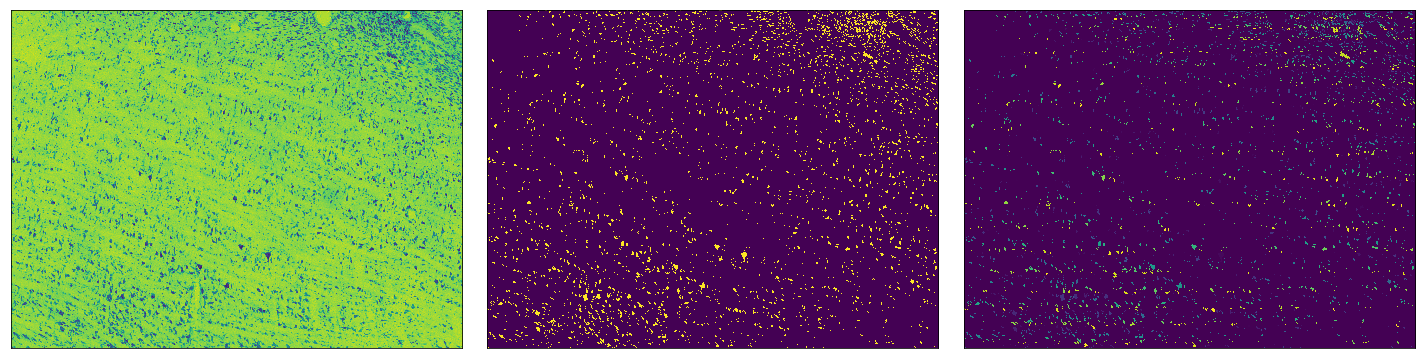

In [10]:
display_images_in_grids([im_rescale[secIndex],im_BW[secIndex],im_label[secIndex]],nc=3)

### Visualize consecutive images at the position of detected blobs

Blob Index 99


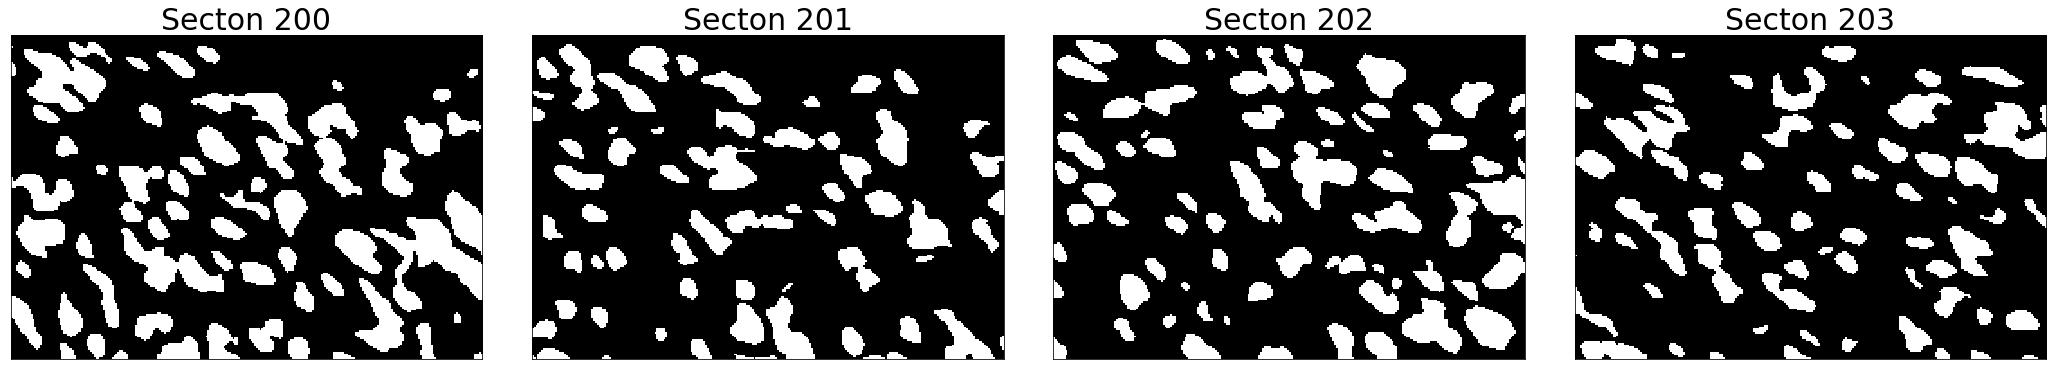

Blob Index 2490


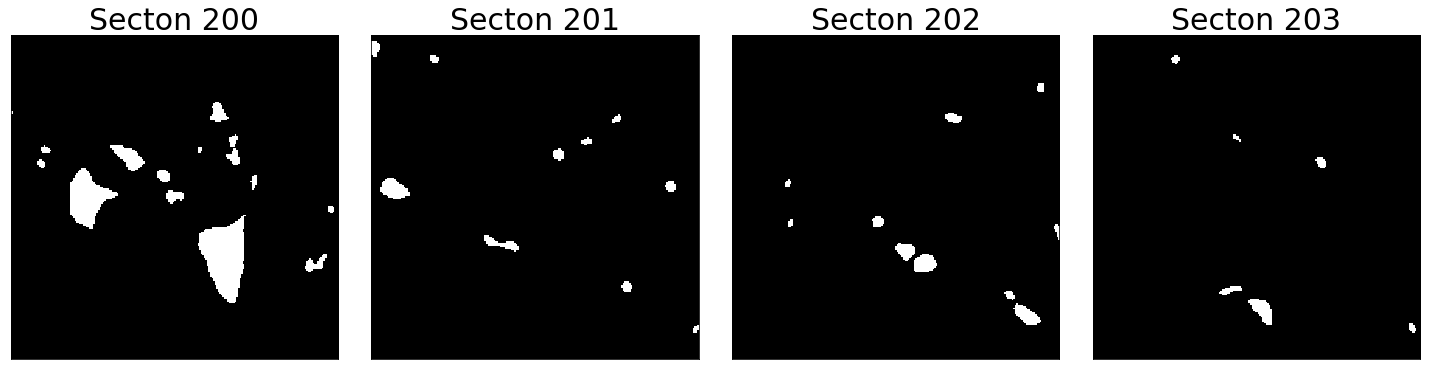

Blob Index 511


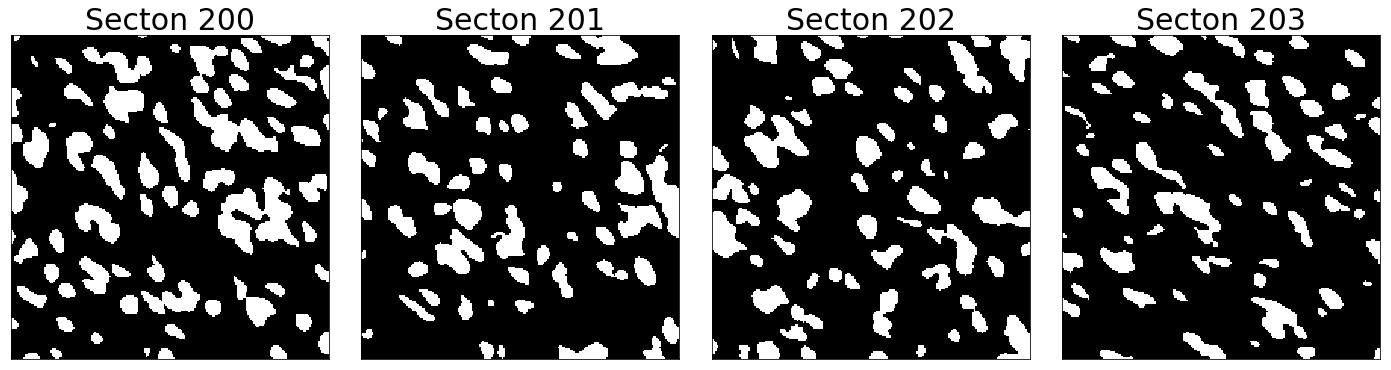

Blob Index 3432


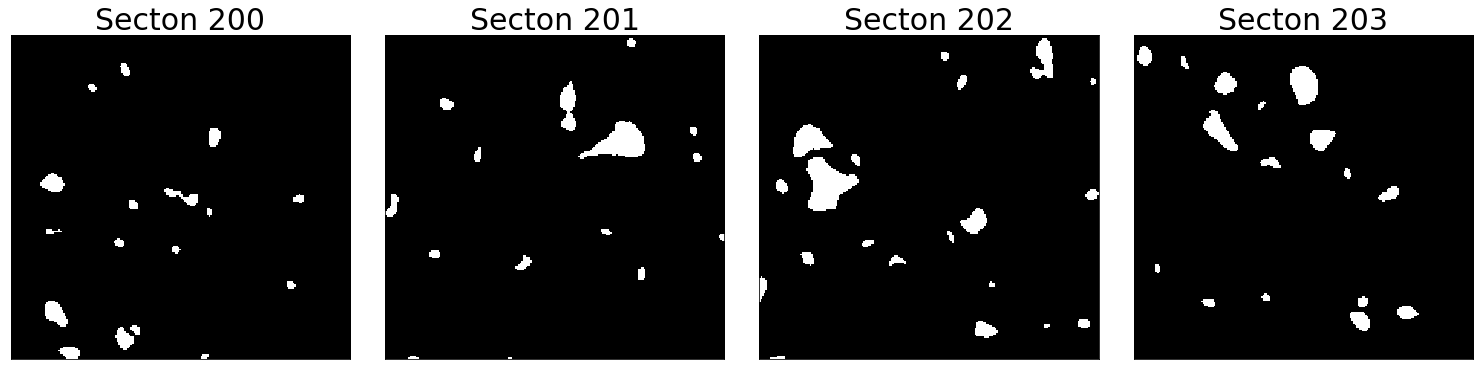

Blob Index 1312


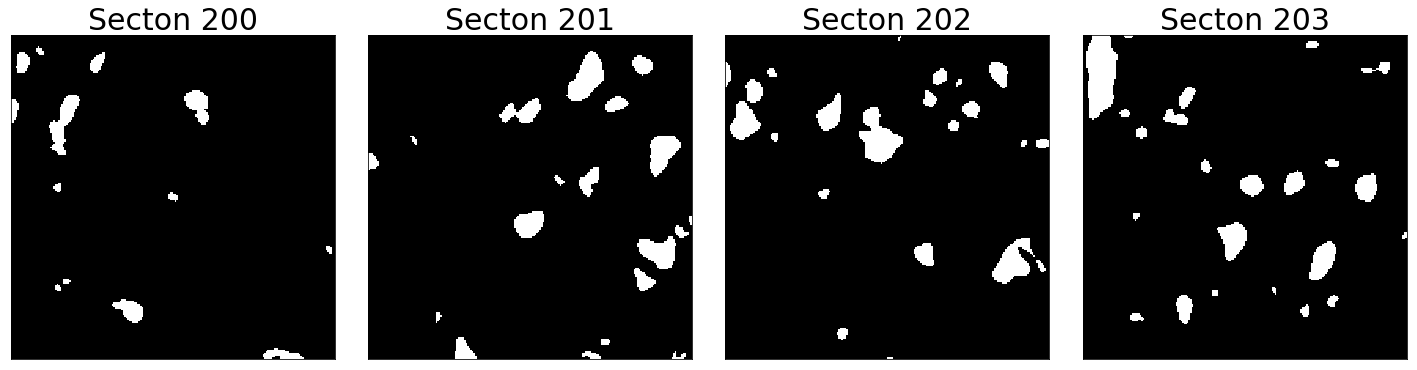

Blob Index 790


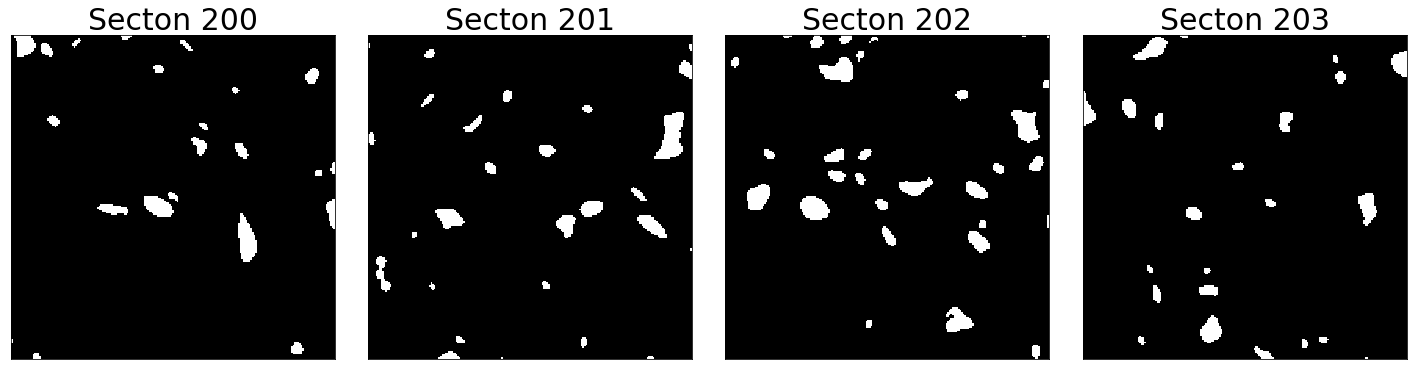

Blob Index 1141


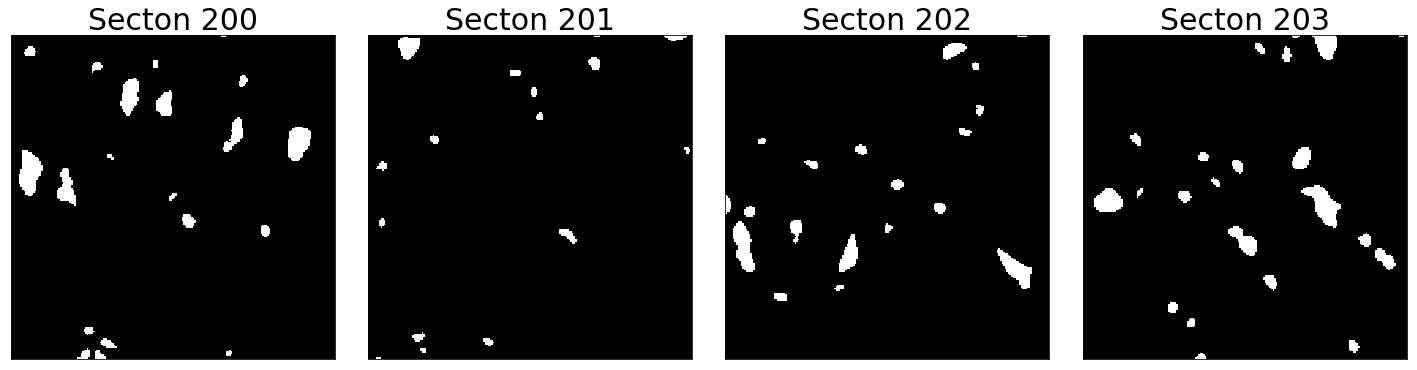

Blob Index 4071


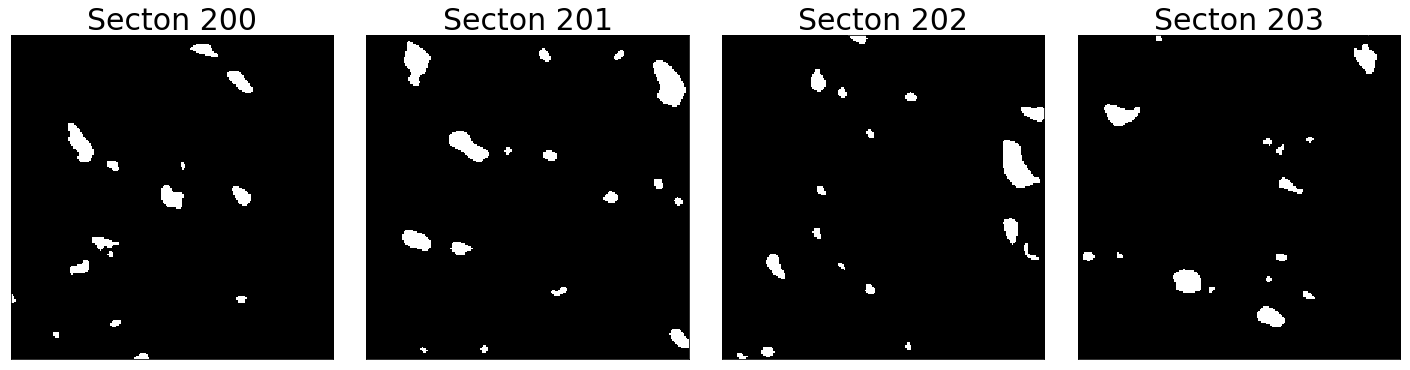

Blob Index 3396


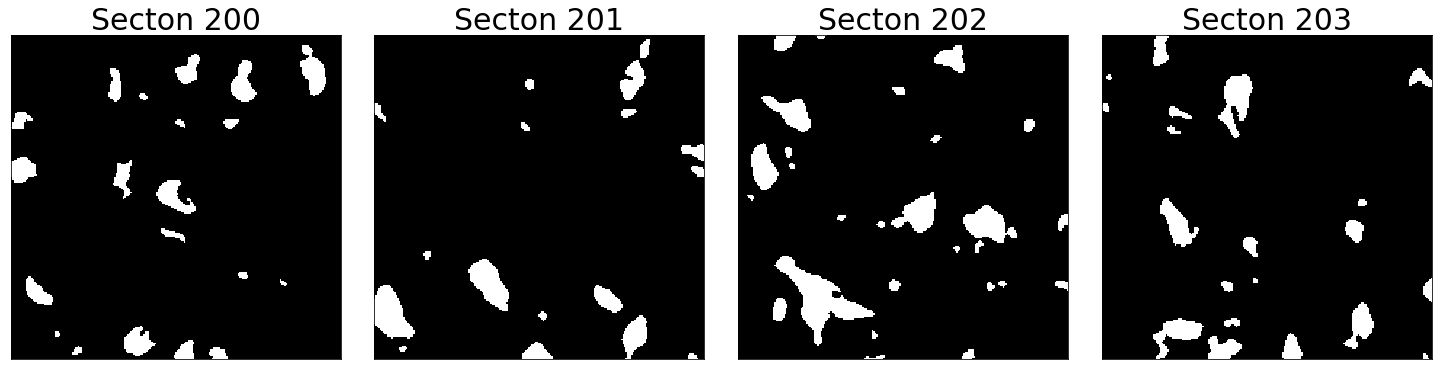

Blob Index 1398


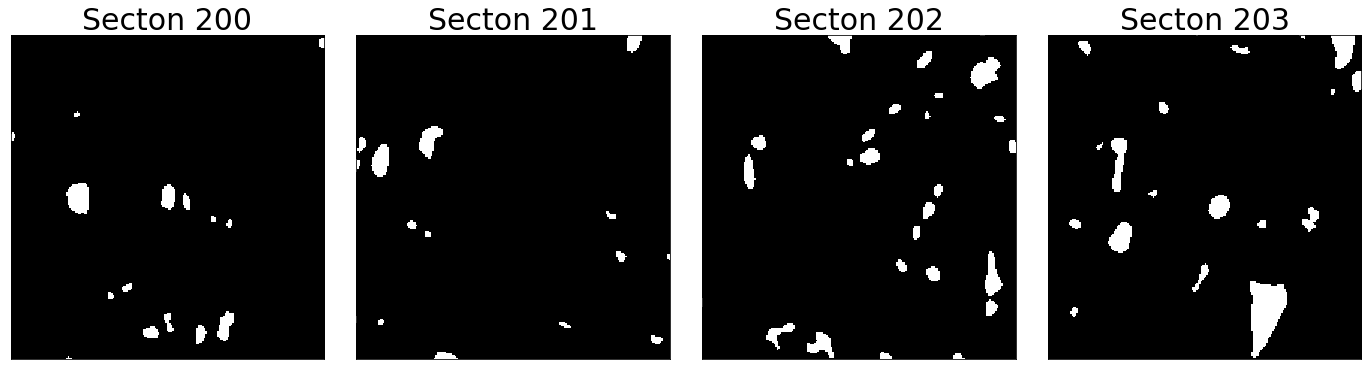

In [18]:
secIndex = 0
option_vis_blob_margin = 100
sec = 200
for tempBlobIndex in np.random.choice(range(0,n_blobs[secIndex]),10):
    print('Blob Index %d' % tempBlobIndex)
#     display_images_in_grids([fun_crop_images(im_rescale[tempSecIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margin) 
#                              for tempSecIndex in range(n_images)],
#                             titles=['Secton %d' % tempSec for tempSec in secIndexList],
#                             nc=5,cmap=plt.cm.gray)
    display_images_in_grids([fun_crop_images(im_BW[tempSecIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margin) 
                         for tempSecIndex in range(n_images)],
                        titles=['Secton %d' % tempSec for tempSec in secIndexList],
                        nc=4,cmap=plt.cm.gray)

### Get blob properties in the next section

In [15]:
secIndex = 0
sec = secIndexList[secIndex]
blobID = 818
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
o_scan_size_coeff = 5

In [16]:
# Get features for the current blob
temp_curr_blob_props = {}
temp_curr_blob_props = im_blob_prop[sec][blobID]

tempB1_idx_loc = temp_curr_blob_props['centroid']
tempB1_orientation = temp_curr_blob_props['orientation']
tempB1_hu = temp_curr_blob_props['moments_hu']
tempB1_size = temp_curr_blob_props['area']

temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

In [17]:

temp_next_secIdx = min(secIndex + 1, n_images)
temp_next_sec = secIndexList[temp_next_secIdx]
# List of centroid in the next section
temp_next_blob_centroid = [im_blob_prop[temp_next_sec][tempBIdx]['centroid'] for tempBIdx in range(n_blobs[temp_next_secIdx])]
tempPath = matplotlib.path.Path(temp_next_sec_range)
tempBlobInside = tempPath.contains_points(temp_next_blob_centroid)
tempBlobInsideIndex = np.arange(0,n_blobs[temp_next_secIdx], dtype=np.int32)
tempBlobInsideIndex = tempBlobInsideIndex[tempBlobInside]
temp_next_n_blob = np.count_nonzero(tempBlobInside)
if temp_next_n_blob:
    temp_next_sec_image_blob_prop = np.array(im_blob_prop[temp_next_sec])[tempBlobInside]
else:
    print('No Blobs found.')    


# Blob comparsion

In [19]:
temp_next_blob_props = {}
for tempProp in prop:
    temp_prop_value = []
    for blobIndex in range(temp_next_n_blob):
        temp_prop_value.append(temp_next_sec_image_blob_prop[blobIndex][tempProp])
    temp_next_blob_props[tempProp] = temp_prop_value
temp_next_blob_props['relative_dict'] = []
for blobIndex in range(temp_next_n_blob):
    temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_image_blob_prop[blobIndex]['centroid'],local_cloc))

In [26]:
[temp_next_blob_props['moments_hu'][tempBIdx][0] for tempBIdx in r

0.1861291532584447

In [496]:
temp_sim = {}
temp_compare_props = ['area', 'orientation', 'eccentricity']
for temp_prop in temp_compare_props:
    if temp_prop == 'orientation':
        temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                 temp_next_blob_props[temp_prop],distance_type='angular'))
    else:
        temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                 temp_next_blob_props[temp_prop]))

In [497]:
compare_weight = [6,1,3]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.7
o_scan_size_coeff = 4

In [498]:
temp_weighted_sim = np.dot(np.transpose(np.stack(temp_sim.values())),compare_weight)

In [499]:
temp_next_sec_range1 = fun_scan_range(tempB1_idx_loc,5*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='1D')[0]
temp_next_sec_image = fun_crop_images(im_label[temp_next_secIdx],*temp_next_sec_range1,im1max=im1max,im0max=im0max)

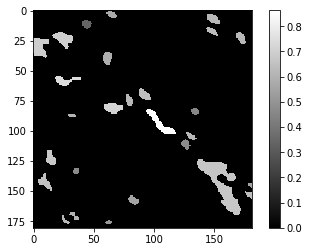

In [500]:
temp_next_sec_image_sim = fun_crop_images(im_label[temp_next_secIdx],*temp_next_sec_range_1D).astype(np.float)
for tempIndex in range(len(temp_weighted_sim)):
#     print(tempIndex)
#     print('Blob %d value replaced to be %f  '%(tempBlobInsideIndex[tempIndex],temp_weighted_sim[tempIndex]))
    temp_matched_pixel = (temp_next_sec_image_sim == (1+tempBlobInsideIndex[tempIndex]))
#     print('Number of pixel value replaced = %d \n'% np.count_nonzero(temp_matched_pixel))
    temp_next_sec_image_sim[temp_matched_pixel] = temp_weighted_sim[tempIndex]
temp_next_sec_image_sim[np.logical_or(temp_next_sec_image_sim<0,temp_next_sec_image_sim>1)] = 0
# temp_next_sec_image_sim[temp_next_sec_image_sim < o_simil_threshold] = 0
plt.imshow(temp_next_sec_image_sim, cmap=plt.cm.gray)
plt.colorbar()

In [501]:
temp_weighted_sim

array([ 0.5752182 ,  0.61803928,  0.34141786,  0.63460258,  0.69589568,
        0.61858316,  0.69117262,  0.58974994,  0.74495251,  0.63794804,
        0.62130839,  0.71378704,  0.45712768,  0.86306217,  0.60448978,
        0.61985468,  0.47368528,  0.67602911,  0.66977274,  0.46566156,
        0.6511823 ,  0.55671776,  0.64069481,  0.55001377,  0.60471147,
        0.61717508,  0.50949045])

In [502]:
temp_compare_result = temp_weighted_sim>o_simil_threshold
temp_compare_result = any(temp_compare_result.tolist())

In [503]:
temp_compare_result

True

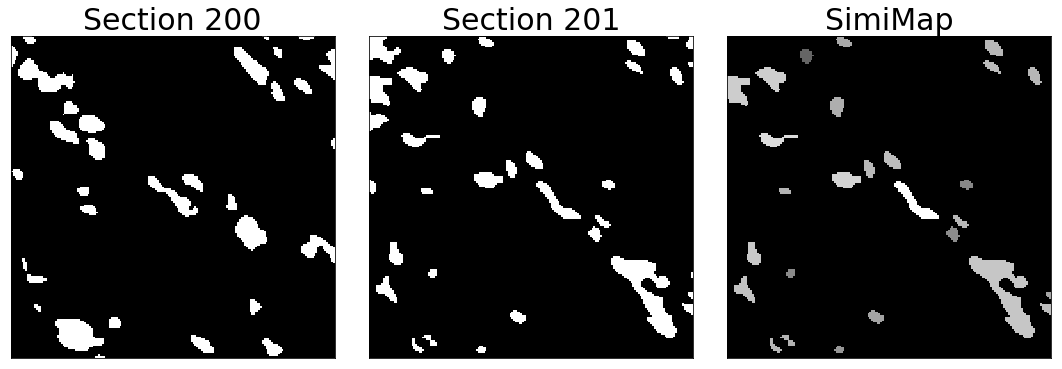

In [504]:
display_images_in_grids([ fun_crop_images(im_BW[secIndex],*temp_next_sec_range_1D).astype(float) , 
                         fun_crop_images(im_BW[temp_next_secIdx],*temp_next_sec_range_1D).astype(float),
                         temp_next_sec_image_sim],
                        nc=3,titles=['Section %d'%sec, 'Section %d'%temp_next_sec,'SimiMap'], cmap=plt.cm.gray)

# Integrated - blob comparsion

In [534]:
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox']
compare_props = ['area', 'orientation', 'eccentricity']
compare_weight = [6,1,3]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.9
o_scan_size_coeff = 5
o_record_similar_blob_next_sec = True

In [535]:
n_blobs = map(len, im_blob_prop.values())

In [536]:
im_blob_typical[tempSec] = np.zeros((n_blobs[tempSecIndex],1),dtype=bool)

In [537]:
im_blob_prop[sec][0]

In [538]:
im_blob_typical = {}
im_blob_sim_score = {}
im_blob_sim_crop_im = {}
im_blob_crop_range_1D = {}
# Initialize recording variable: im_blob_typical (initialized to be nontypical) & im_blob_sim_score: highest similarity for each blob in each section
for tempSecIndex in range(n_images):
    tempSec = secIndexList[tempSecIndex]
    im_blob_typical[tempSec] = np.zeros((n_blobs[tempSecIndex],1),dtype=bool)
    im_blob_sim_score[tempSec] = np.zeros((n_blobs[tempSecIndex],1),dtype=float)
    im_blob_sim_crop_im[tempSec] = {}
    im_blob_crop_range_1D[tempSec] = {}
# tempRegion1 = im_blob_prop[sec][blobID]

secIndex = 0
sec = secIndexList[secIndex]
temp_next_secIdx = secIndex + 1;
if temp_next_secIdx < n_images:
    temp_next_sec = secIndexList[temp_next_secIdx]
else:
    sys.stderr('Reach the limit of the stack...')
# blobID = 142
# n_blobs = len(im_blob_prop[sec])
temp_next_blob_centroid = [im_blob_prop[temp_next_sec][tempBIdx]['centroid'] for tempBIdx in range(n_blobs[temp_next_secIdx])]


for blobID in range(n_blobs[secIndex]):
# for blobID in range(10,11):
    # Initialization. 
    
    temp_curr_blob_props = {}
    for tempProp in prop:
        temp_curr_blob_props[tempProp] = im_blob_prop[sec][blobID][tempProp]

    tempB1_radius = fun_radius_bbox(*temp_curr_blob_props['bbox'])
    tempB1_idx_loc = temp_curr_blob_props['centroid']
    tempB1_orientation = temp_curr_blob_props['orientation']
    tempB1_hu = temp_curr_blob_props['moments_hu']
    tempB1_size = temp_curr_blob_props['area']

    temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props['bbox']),im0max=im0max,im1max=im1max,o_form='2D')
    temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props['bbox']),im0max=im0max,im1max=im1max)
    
    
    tempPath = matplotlib.path.Path(temp_next_sec_range)
    tempBlobInside = tempPath.contains_points(temp_next_blob_centroid)
    tempBlobInsideIndex = np.arange(0,n_blobs[temp_next_secIdx], dtype=np.int32)
    tempBlobInsideIndex = tempBlobInsideIndex[tempBlobInside]
    temp_next_n_blob = np.count_nonzero(tempBlobInside)
    if temp_next_n_blob:
#         print('Scaning BlobID %d: Blobs found in the next section.'% blobID)
        temp_next_sec_image_blob_prop = np.array(im_blob_prop[temp_next_sec])[tempBlobInside]
    else:
#         print('Scanning BlobID %d: No Blobs found in the next section.'% blobID)
        continue
    
    temp_next_blob_props = {}
    for tempProp in prop:
        temp_prop_value = []
        for blobIndex in range(temp_next_n_blob):
            temp_prop_value.append(temp_next_sec_image_blob_prop[blobIndex][tempProp])
        temp_next_blob_props[tempProp] = temp_prop_value
    temp_next_blob_props['relative_dict'] = []
    for blobIndex in range(temp_next_n_blob):
        temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_image_blob_prop[blobIndex]['centroid'],local_cloc))

    temp_sim = {}
    for temp_prop in temp_compare_props:
        if temp_prop == 'orientation':
            temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                     temp_next_blob_props[temp_prop],distance_type='angular'))
        else:
            temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                     temp_next_blob_props[temp_prop]))
    temp_weighted_sim = np.dot(np.transpose(np.stack(temp_sim.values())),compare_weight)

    temp_compare_result = temp_weighted_sim>o_simil_threshold
    temp_compare_result = any(temp_compare_result.tolist())
    if o_record_similar_blob_next_sec:
        temp_next_sec_image_sim = fun_crop_images(im_label[temp_next_secIdx],*temp_next_sec_range_1D).astype(np.float)
        for tempIndex in range(len(temp_weighted_sim)):
            temp_next_sec_image_sim[temp_next_sec_image_sim == (1+tempBlobInsideIndex[tempIndex])] = temp_weighted_sim[tempIndex]
#         plt.imshow(temp_next_sec_image_sim, cmap=plt.cm.gray)
        temp_next_sec_image_sim[np.logical_or(temp_next_sec_image_sim<0,temp_next_sec_image_sim>1)] = 0
        im_blob_sim_crop_im[sec][blobID] = temp_next_sec_image_sim
    
    im_blob_crop_range_1D[sec][blobID] = temp_next_sec_range_1D    
    im_blob_sim_score[sec][blobID] = np.max(temp_weighted_sim)
    im_blob_typical[sec][blobID] = temp_compare_result


In [542]:
temp_num_blob_matched = np.count_nonzero(im_blob_typical[200])
temp_matched_blob_index = np.nonzero(im_blob_typical[200])[0].tolist()

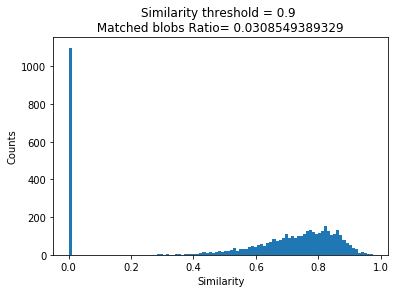

In [543]:
# Statistics
temp_ratio_blob_matched = np.count_nonzero(im_blob_typical[sec])/float(n_blobs[secIndex])
fig_hist_simscore_sec200 = plt.figure();
fig_hist_simscore_sec200 = plt.hist(im_blob_sim_score[200],bins=100);
fig_hist_simscore_sec200 = plt.xlabel('Similarity')
fig_hist_simscore_sec200 = plt.ylabel('Counts')
fig_hist_simscore_sec200 = plt.title('Similarity threshold = %s \n Matched blobs Ratio= %s '% (o_simil_threshold,temp_ratio_blob_matched))

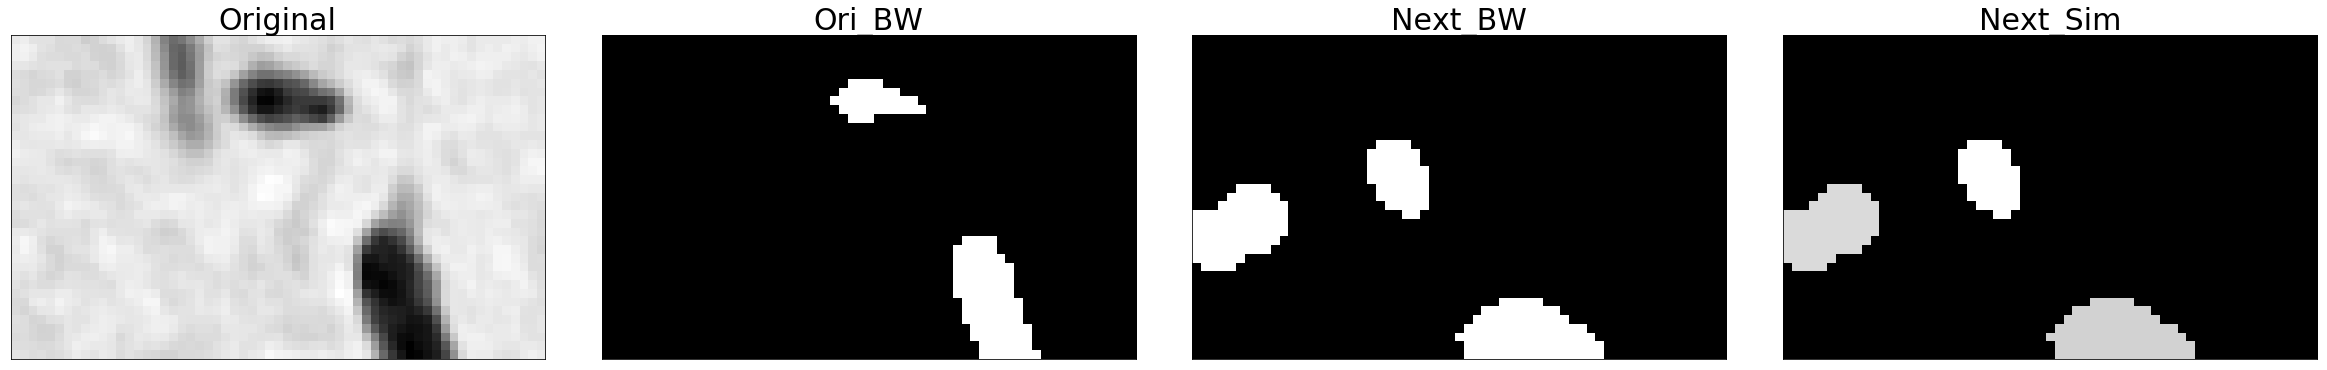

In [540]:
tempBlobIndex = 10
display_images_in_grids([    
        fun_rescale_grayscale_image(fun_crop_images(im_cropped[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),pvmax=1),
    fun_crop_images(im_BW[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),
    fun_crop_images(im_BW[secIndex+1],*im_blob_crop_range_1D[sec][tempBlobIndex]),
    im_blob_sim_crop_im[sec][tempBlobIndex]
                            ],titles=['Original','Ori_BW','Next_BW','Next_Sim'],
                            nc=4,cmap=plt.cm.gray)

In [1]:
# Check if really similar
option_vis_blob_margion = 30
for tempBlobIndex in np.random.choice(temp_matched_blob_index,20):
    print('Blob ID %d'%tempBlobIndex)
    display_images_in_grids([    
        fun_rescale_grayscale_image(fun_crop_images(im_cropped[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),pvmax=1),
    fun_crop_images(im_BW[secIndex],*im_blob_crop_range_1D[sec][tempBlobIndex]),
    fun_rescale_grayscale_image(fun_crop_images(im_cropped[secIndex+1],*im_blob_crop_range_1D[sec][tempBlobIndex])),
    im_blob_sim_crop_im[sec][tempBlobIndex]
    ],titles=['Original','Ori_BW','Next','Next_SimScore'],
                            nc=4,cmap=plt.cm.gray)

NameError: name 'np' is not defined